In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
tf.set_random_seed(42)

from imutils import paths
import os

from PIL import Image
import glob

import pandas as pd

In [2]:
imgFiles = glob.glob("sampleData/*.pgm")

print("Sample_files: ")
print(imgFiles[:5])

print("No of images: ")
print(len(imgFiles))

Sample_files: 
['sampleData/71__M_Left_ring_finger_Zcut.pgm', 'sampleData/59__F_Left_middle_finger_Obl.pgm', 'sampleData/39__M_Right_little_finger_Obl.pgm', 'sampleData/52__M_Right_little_finger_Real.pgm', 'sampleData/26__M_Left_index_finger_Real.pgm']
No of images: 
3976


In [3]:
X = []
y = []

for fName in imgFiles:
    X_i = Image.open(fName) #sampleData/17__M_Left_index_finger_Real.BMP
    X_i = np.array(X_i.resize((64,64)))/255.0
    eList = fName.split(os.path.sep) #['sampleData', '17_M_Left_index_finger_Real.BMP']
    X.append(X_i)
    label = eList[1].split('_')
    fLabel = label[6].split('.')#['Zcut', 'pgm']
    y.append(fLabel[0])
    

In [4]:
print(set(y))

{'Real', 'Zcut', 'CR', 'Obl'}


In [5]:
from sklearn.preprocessing import LabelEncoder

lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)

print(set(y))

{0, 1, 2, 3}


In [6]:
print("Encoder classes: ", lEncoder.classes_)

Encoder classes:  ['CR' 'Obl' 'Real' 'Zcut']


In [7]:
print(lEncoder.inverse_transform([0]))

['CR']


In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape:  (3180, 64, 64, 1)
X_test.shape:  (796, 64, 64, 1)
y_train.shape (3180,)
y_test.shape (796,)


## Convolution structure

In [10]:
model_CNN = keras.models.Sequential()
model_CNN.add(keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", 
                                 activation = "relu", input_shape = [64,64,1]))
model_CNN.add(keras.layers.MaxPooling2D(pool_size = 2))

model_CNN.add(keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same",activation = "relu"))
model_CNN.add(keras.layers.MaxPooling2D(pool_size = 2))

model_CNN.add(keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model_CNN.add(keras.layers.Flatten())
model_CNN.add(keras.layers.Dense(units = 64, activation = 'relu'))
model_CNN.add(keras.layers.Dense(units = 32, activation = 'relu'))
model_CNN.add(keras.layers.Dense(units = 4, activation = 'softmax'))
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
__________

In [12]:
model_CNN.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("soco_model.h5", save_best_only=True),
]

history_CNN = model_CNN.fit(X_train, y_train, epochs = 100, 
                            validation_split = 0.1, batch_size = 32, 
                            callbacks = callbacks)

Train on 2862 samples, validate on 318 samples
Epoch 1/100
2862/2862 [==============================] - 27s 10ms/sample - loss: 1.3603 - acc: 0.2977 - val_loss: 1.3281 - val_acc: 0.3648
Epoch 2/100
2862/2862 [==============================] - 38s 13ms/sample - loss: 1.1960 - acc: 0.3983 - val_loss: 1.1835 - val_acc: 0.4119
Epoch 3/100
2862/2862 [==============================] - 49s 17ms/sample - loss: 1.1077 - acc: 0.4462 - val_loss: 1.1119 - val_acc: 0.4434
Epoch 4/100
2862/2862 [==============================] - 51s 18ms/sample - loss: 1.0208 - acc: 0.4986 - val_loss: 1.1083 - val_acc: 0.4906
Epoch 5/100
2862/2862 [==============================] - 48s 17ms/sample - loss: 0.9685 - acc: 0.5241 - val_loss: 0.9628 - val_acc: 0.5314
Epoch 6/100
2862/2862 [==============================] - 46s 16ms/sample - loss: 0.8686 - acc: 0.5922 - val_loss: 0.9599 - val_acc: 0.5252
Epoch 7/100
2862/2862 [==============================] - 53s 18ms/sample - loss: 0.7692 - acc: 0.6576 - val_loss: 0.800

In [13]:
best_model = keras.models.load_model('soco_model.h5')

In [14]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print("Test loss: {} and Test accuracy: {}".format(test_loss, test_accuracy))

796/796 [==============================] - 2s 3ms/sample - loss: 0.5297 - acc: 0.7940
Test loss: 0.5297234130265126 and Test accuracy: 0.7939698696136475


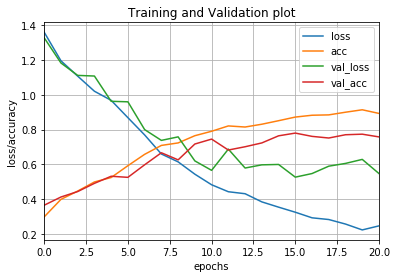

In [17]:
pd.DataFrame(history_CNN.history).plot()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel("loss/accuracy")
plt.title("Training and Validation plot")
plt.show()